In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
use_simulated = True

if use_simulated: 
    data = np.load('../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz')
    g_obs = np.array(data['g_obs'])
else: 
    data_dir = '../../../../fastStructure/hgdp_data/huang2011_plink_files/'
    filenamebase = 'phased_HGDP+India+Africa_2810SNPs-regions1to36'
    filename = data_dir + filenamebase + '.npz'
    data = np.load(filename)

    g_obs = np.array(data['g_obs'])
    g_obs_raw = np.array(data['g_obs_raw'])

    # just checking ... 
    which_missing = (g_obs_raw == 3)
    (g_obs.argmax(-1) == g_obs_raw)[~which_missing].all()
    (g_obs[which_missing] == 0).all()

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

20
50


# Get prior

In [6]:
use_bnp_prior = False

In [7]:
_, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict = prior_params_paragami.random(key=jax.random.PRNGKey(41))
prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

print(prior_params_dict)

OrderedDict([('dp_prior_alpha', DeviceArray([2.59776136], dtype=float64)), ('allele_prior_alpha', DeviceArray([1.15564526], dtype=float64)), ('allele_prior_beta', DeviceArray([1.0515046], dtype=float64))])


# Get VB params 

In [40]:
k_approx = 3

In [41]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [42]:
use_logitnormal_sticks = False

_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 3, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (20, 2, 2) (lb=0.0, ub=inf)


In [43]:
vb_params_dict = vb_params_paragami.random(key=jax.random.PRNGKey(41))

In [44]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict, use_bnp_prior)

dirch prior!


DeviceArray(2258.61086696, dtype=float64)

# Get moments from vb parameters

In [45]:
dp_prior_alpha = prior_params_dict['dp_prior_alpha']
allele_prior_alpha = prior_params_dict['allele_prior_alpha']
allele_prior_beta = prior_params_dict['allele_prior_beta']

# get initial moments from vb_params
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(
            vb_params_dict, gh_loc, gh_weights)

e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
            e_log_sticks, e_log_1m_sticks)

# Population beta update

In [46]:
update_pop_beta = jax.jit(cavi_lib.update_pop_beta)

In [47]:
beta_param_update = update_pop_beta(g_obs, e_log_pop_freq, e_log_1m_pop_freq, 
                                        e_log_cluster_probs, prior_params_dict)

### check against autograd

In [48]:
joint_loglik = lambda *x : structure_model_lib.\
                    get_e_joint_loglik_from_nat_params(*x,
                                                       use_bnp_prior=use_bnp_prior, 
                                                       detach_ez=True)[0]

In [49]:
get_pop_beta_update1_ag = jax.jit(jax.jacobian(joint_loglik, argnums=1))
get_pop_beta_update2_ag = jax.jit(jax.jacobian(joint_loglik, argnums=2))

In [50]:
beta_update1 = get_pop_beta_update1_ag(g_obs,
                                    e_log_pop_freq, e_log_1m_pop_freq,
                                    e_log_sticks, e_log_1m_sticks,
                                    dp_prior_alpha, allele_prior_alpha,
                                    allele_prior_beta).block_until_ready()

dirch prior!


In [51]:
beta_update2 = get_pop_beta_update2_ag(g_obs,
                                    e_log_pop_freq, e_log_1m_pop_freq,
                                    e_log_sticks, e_log_1m_sticks,
                                    dp_prior_alpha, allele_prior_alpha,
                                    allele_prior_beta).block_until_ready()

dirch prior!


In [52]:
np.abs(beta_param_update[0][:, :, 0] - 1 - beta_update1).max()

DeviceArray(7.10542736e-15, dtype=float64)

In [53]:
np.abs(beta_param_update[0][:, :, 1] - 1 - beta_update2).max()

DeviceArray(7.10542736e-15, dtype=float64)

### Timing

It should be faster than the autograd updates ... otherwise why not just use autograd updates

In [54]:
t0 = time.time() 

_ = get_pop_beta_update1_ag(g_obs,
                            e_log_pop_freq, e_log_1m_pop_freq,
                            e_log_sticks, e_log_1m_sticks,
                            dp_prior_alpha, allele_prior_alpha,
                            allele_prior_beta).block_until_ready()

_ = get_pop_beta_update2_ag(g_obs,
                            e_log_pop_freq, e_log_1m_pop_freq,
                            e_log_sticks, e_log_1m_sticks,
                            dp_prior_alpha, allele_prior_alpha,
                            allele_prior_beta).block_until_ready()

print(time.time() - t0)

0.002935171127319336


In [55]:
t0 = time.time() 

out = update_pop_beta(g_obs, e_log_pop_freq, e_log_1m_pop_freq, 
                        e_log_cluster_probs, prior_params_dict)

out[0].block_until_ready()
print(time.time() - t0)

0.0010650157928466797


# Admixture stick updates

In [56]:
update_ind_admix_beta = jax.jit(lambda *x : cavi_lib.update_ind_admix_beta(*x, use_bnp_prior = use_bnp_prior))

In [57]:
ind_admix_beta_update = update_ind_admix_beta(g_obs, e_log_pop_freq, e_log_1m_pop_freq, 
                            e_log_cluster_probs, prior_params_dict)

dirch prior


In [58]:
get_stick_update1_ag = jax.jit(jax.jacobian(joint_loglik, argnums=3))
get_stick_update2_ag = jax.jit(jax.jacobian(joint_loglik, argnums=4))

In [59]:
stick_update1 = get_stick_update1_ag(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta)

stick_update2 = get_stick_update2_ag(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta)

dirch prior!
dirch prior!


In [60]:
np.abs(stick_update1 + 1 -  ind_admix_beta_update[0][:, :, 0]).max()

DeviceArray(3.55271368e-14, dtype=float64)

In [61]:
np.abs(stick_update2 + 1 - ind_admix_beta_update[0][:, :, 1]).max()

DeviceArray(2.84217094e-14, dtype=float64)

### Timing

It should be faster than the autograd updates ... otherwise why not just use autograd updates

In [62]:
t0 = time.time() 

_ = get_stick_update1_ag(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta).block_until_ready()

_ = get_stick_update2_ag(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta).block_until_ready()
print(time.time() - t0)

0.0035614967346191406


In [63]:
t0 = time.time() 

out = update_ind_admix_beta(g_obs, e_log_pop_freq, e_log_1m_pop_freq, 
                            e_log_cluster_probs, prior_params_dict)
out[0].block_until_ready()

print(time.time() - t0)

0.0012943744659423828


In [64]:
foo = cavi_lib.run_cavi(g_obs, vb_params_dict,
                vb_params_paragami,
                prior_params_dict, 
                use_bnp_prior = use_bnp_prior,
                debug = True)

Compiling cavi functions ...
dirch prior
dirch prior!
CAVI compile time: 2.9sec

 running CAVI ...
iteration [1]; kl:1488.189139; elapsed: 0.0023secs
iteration [2]; kl:1480.661813; elapsed: 0.1008secs
iteration [3]; kl:1474.236004; elapsed: 0.0236secs
iteration [4]; kl:1467.614735; elapsed: 0.0062secs
iteration [5]; kl:1460.231436; elapsed: 0.0061secs
iteration [6]; kl:1451.723197; elapsed: 0.0054secs
iteration [7]; kl:1441.962349; elapsed: 0.005secs
iteration [8]; kl:1431.117438; elapsed: 0.0049secs
iteration [9]; kl:1419.621032; elapsed: 0.0049secs
iteration [10]; kl:1407.996618; elapsed: 0.0051secs
iteration [11]; kl:1396.617434; elapsed: 0.005secs
iteration [12]; kl:1385.465296; elapsed: 0.0048secs
iteration [13]; kl:1372.859612; elapsed: 0.005secs
iteration [14]; kl:1363.901708; elapsed: 0.005secs
iteration [15]; kl:1355.687501; elapsed: 0.0048secs
iteration [16]; kl:260.700177; elapsed: 0.005secs
iteration [17]; kl:1362.587706; elapsed: 0.005secs
iteration [18]; kl:1351.750909; e

iteration [180]; kl:1345.583685; elapsed: 0.0051secs
iteration [181]; kl:1345.311622; elapsed: 0.0061secs
iteration [182]; kl:1345.020051; elapsed: 0.005secs
iteration [183]; kl:1344.70296; elapsed: 0.005secs
iteration [184]; kl:1344.350766; elapsed: 0.0049secs
iteration [185]; kl:1343.947126; elapsed: 0.005secs
iteration [186]; kl:1343.461186; elapsed: 0.0051secs
iteration [187]; kl:1342.824412; elapsed: 0.0052secs
iteration [188]; kl:1341.831007; elapsed: 0.0049secs
iteration [189]; kl:1338.986226; elapsed: 0.005secs
iteration [190]; kl:1338.852599; elapsed: 0.0047secs
iteration [191]; kl:1342.244887; elapsed: 0.0048secs
iteration [192]; kl:1340.250649; elapsed: 0.0049secs
iteration [193]; kl:1332.461445; elapsed: 0.005secs
iteration [194]; kl:1345.021087; elapsed: 0.0049secs
iteration [195]; kl:1344.555344; elapsed: 0.005secs
iteration [196]; kl:1344.016908; elapsed: 0.0049secs
iteration [197]; kl:1343.355823; elapsed: 0.0049secs
iteration [198]; kl:1342.449244; elapsed: 0.0049secs


In [65]:
import vb_lib.plotting_utils as plotting_utils

In [66]:
b = plotting_utils.get_vb_expectations(foo[0])[1]

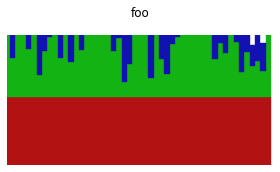

In [67]:
plotting_utils.plot_admixture(b, 'foo')

In [68]:
b

DeviceArray([[0.52406918, 0.88914432, 0.38220915],
             [0.52359033, 0.30355204, 0.36687398],
             [0.52358061, 0.49119477, 0.23230164],
             [0.52459251, 0.93795644, 0.37148539],
             [0.52372199, 0.37037886, 0.63831945],
             [0.52390001, 0.56699148, 0.84657135],
             [0.52358612, 0.17279981, 0.72272331],
             [0.52357399, 0.35144265, 0.3410362 ],
             [0.52340731, 0.45949359, 0.15047138],
             [0.52367858, 0.53912765, 0.37737804],
             [0.52364572, 0.30160439, 0.53605435],
             [0.52508783, 0.93201406, 0.92925276],
             [0.52405472, 0.26965934, 0.91341434],
             [0.52395073, 0.82970029, 0.6728091 ],
             [0.52375347, 0.36175896, 0.78194177],
             [0.52380956, 0.7805416 , 0.44967549],
             [0.52362662, 0.55722529, 0.3352773 ],
             [0.52383146, 0.76900779, 0.60562019],
             [0.52370685, 0.70971747, 0.35072283],
             [0.52371472, 0.673